In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
import gym
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
import matplotlib.pyplot as plt3
from gym import wrappers
from collections import deque
import random
import numpy as np
import math
import os
%matplotlib inline

from gym import logger as gymlogger
from gym.wrappers import Monitor
from IPython.display import HTML
import progressbar
import glob
import io
import base64
from IPython import display as ipythondisplay

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
#from keras.callbacks import TensorBoard
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras.models import Model

Environment

In [9]:
class PheonixEnvironment(gym.Env):
  def __init__(self):
    self.env = gym.make('CartPole-v0')
    self.num_states = self.env.observation_space.shape[0]
    self.num_actions = self.env.action_space.n
    self.deque_list = deque(maxlen=10000)
    self.gamma = 0.9
    self.episodes = 2000
    self.timesteps = 0
    self.min_batch_size = 32
    self.clip = 0.2
    self.entropy = 5e-10
    self.alpha = 3e-4
    self.reward_per_episode = []
    self.avg_rewards = []
    self.steps_per_episode = []
    self.rewards = []
    self.states = []
    self.actions = []
    self.probabilities = []

    self.actor_model, self.critic_model = self.create_model()
    self.actor_model._make_predict_function()
    self.critic_model._make_predict_function()

  def reset_all(self):
    self.rewards = []
    self.states = []
    self.actions = []
    self.probabilities = []
    return self.env.reset()

  def preprocess(self, state):
    return np.reshape(state,(1, self.num_states))

  def create_model(self):
    inputs = Input(shape=(4,))
    
    X = Dense(128, activation="relu")(inputs)

    x_actor = Dense(self.num_actions, activation="softmax")(X)
    x_critic = Dense(1, activation='linear')(X)

    def custom_loss_fn(y_true, y_pred):
      ## Implemented as illustrated in - Creating custom losses in keras
      ## Url : https://keras.io/api/losses/
      ## Loss calculation implemented as illustrated in - Proximal Policy Optimization Algorithms
      ## Url : https://arxiv.org/abs/1707.06347
      print("In loss fun, y true: ", y_true.shape)
      print("y pred", y_pred)
      advantages, predictions, actions = y_true[:, :1], y_true[:, 1:1+self.num_actions], y_true[:, 1+self.num_actions:]
      prob = y_pred * actions
      old_prob = actions * predictions
      r = prob/(old_prob + 1e-5)
      p1 = r * advantages
      p2 = K.clip(r, min_value=1 - self.clip, max_value=1 + self.clip) * advantages
      loss =  -K.mean(K.minimum(p1, p2) + self.entropy * -(prob * K.log(prob + 1e-8)))
      return loss
        
    actor_model = Model(inputs = inputs, outputs = x_actor)
    actor_model.compile(loss=custom_loss_fn, optimizer=RMSprop(lr=self.alpha))

    critic_model = Model(inputs = inputs, outputs = x_critic)
    critic_model.compile(loss='mse', optimizer=RMSprop(lr=self.alpha))

    return actor_model, critic_model

  def choose_action(self, state):
    #state = np.vstack(state)
    probabilities = self.actor_model.predict(state)[0]
    action = np.random.choice(self.num_actions, p=probabilities)
    return probabilities, action
  
  def calc_rewards(self):
    i = len(self.rewards) - 1
    sum = 0
    disc_rewards = [x*0 for x in range(len(self.rewards))]
    while i >= 0:
      sum = sum * self.gamma + self.rewards[i]
      disc_rewards[i] = sum
      i -= 1
    mu = np.mean(disc_rewards)
    sigma = np.std(disc_rewards)
    disc_rewards -= mu
    disc_rewards /= sigma

    return disc_rewards

  def train(self, states, actions, probabilities):
    disc_rewards = np.vstack(self.calc_rewards())
    v_values = self.critic_model.predict(states)
    advantages = disc_rewards - v_values
    y_true = np.hstack([advantages, probabilities, actions])
    #print("Y true:", y_true.shape)
    self.actor_model.fit(states, y_true, epochs=1, verbose=0, batch_size=len(self.rewards), shuffle=True)
    self.critic_model.fit(states, disc_rewards, epochs=1, verbose=0, batch_size=len(self.rewards), shuffle=True)

  def execute(self):
    for episode in range(self.episodes):
      old_state = self.reset_all()
      old_state = np.expand_dims(old_state, axis=0)
      total_reward = 0
      t = 0
      done = False
      while not done:
        action = np.zeros(self.num_actions)
        probability, a = self.choose_action(old_state)        
        next_state, reward, done, info = self.env.step(a)
        total_reward += reward
        if done and t<195:
          reward = -100
        action[a] = 1
        self.states.append(old_state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.probabilities.append(probability)
        old_state = np.expand_dims(next_state, axis=0)
        
        t += 1
        self.timesteps += 1
        if done:
          self.train(np.vstack(self.states), np.vstack(self.actions), np.vstack(self.probabilities))
          self.reward_per_episode.append(total_reward)
      self.steps_per_episode.append(t)
      print("Episode: ",episode," Total Reward: ", total_reward
            ," Timesteps till now: ", self.timesteps)
      print("Episode: ",episode," Total Reward: ", total_reward," Total timesteps completed: ",self.timesteps, file=open("./gdrive/My Drive/POP_trial1/output.txt", "a"))
    #self.save_results()

  def save_results(self):
    for i in range(self.episodes):
      print(self.reward_per_episode[i], file=open("./gdrive/My Drive/POP_trial1/rewards_per_episode.txt", "a"))
      #print(self.timesteps_per_episode[i], file=open("./gdrive/My Drive/POP_trial1/timesteps_per_episode.txt", "a"))

In [10]:
env = PheonixEnvironment()

In loss fun, y true:  (None, None)
y pred Tensor("dense_5/Softmax:0", shape=(None, 2), dtype=float32)


In [11]:
env.execute()

Episode:  0  Total Reward:  15.0  Timesteps till now:  15
Episode:  1  Total Reward:  10.0  Timesteps till now:  25
Episode:  2  Total Reward:  11.0  Timesteps till now:  36
Episode:  3  Total Reward:  15.0  Timesteps till now:  51
Episode:  4  Total Reward:  17.0  Timesteps till now:  68
Episode:  5  Total Reward:  19.0  Timesteps till now:  87
Episode:  6  Total Reward:  20.0  Timesteps till now:  107
Episode:  7  Total Reward:  78.0  Timesteps till now:  185
Episode:  8  Total Reward:  14.0  Timesteps till now:  199
Episode:  9  Total Reward:  16.0  Timesteps till now:  215
Episode:  10  Total Reward:  27.0  Timesteps till now:  242
Episode:  11  Total Reward:  13.0  Timesteps till now:  255
Episode:  12  Total Reward:  11.0  Timesteps till now:  266
Episode:  13  Total Reward:  12.0  Timesteps till now:  278
Episode:  14  Total Reward:  14.0  Timesteps till now:  292
Episode:  15  Total Reward:  52.0  Timesteps till now:  344
Episode:  16  Total Reward:  17.0  Timesteps till now:  

Results Analysis

Plotting analysis....
Rewards vs episodes


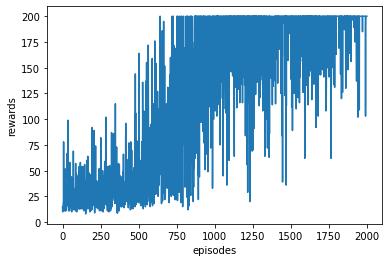

Average Rewards vs episodes


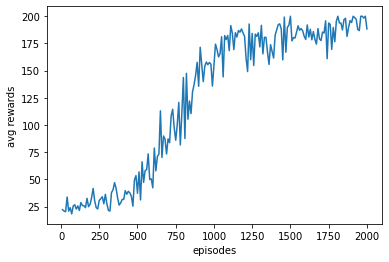

In [12]:
print("Plotting analysis....")
print("Rewards vs episodes")
episodes = list(range(0,env.episodes))
plt1.plot(episodes, env.reward_per_episode)
plt1.xlabel('episodes')
plt1.ylabel('rewards')
plt1.show()

k=0
avg_rewards = []
for i in range(1, int(env.episodes/10)+1):
  avg_rewards.append(np.average(env.reward_per_episode[k:(i*10)-1]))
  k += 10
print("Average Rewards vs episodes")
episodes2 = [x*10 for x in range(1,int(env.episodes/10)+1)]
plt2.plot(episodes2, avg_rewards)
plt2.xlabel('episodes')
plt2.ylabel('avg rewards')
plt2.show()